In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from scipy.fft import fftshift
from cmocean.cm import thermal
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

import lifesim
from inlifesim.spectra import create_pink_psd, rms_frequency_adjust
from inlifesim.util import temp2freq_fft
from lifesim.util.radiation import black_body
import inlifesim as ils

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_6605/3296473734.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path_spectrum = '/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/input_data/Earth_PRTunits_10pc.txt'
path_bs = '/Users/fdannert/Documents/projects/InLIFEsim/working/paper/final_result_table/lookup_table_1e10_Nov24.pkl'

In [3]:
earth_twin = {'distance_s': 10,
              'temp_s': 5778.,
              'radius_s': 1.,
              'lat_s': 0.78,
              'l_sun': 1.,
              'z': 1.,
              'temp_p': 254.,
              'radius_p': 1.,
              'sep_p': 1.,}

dbw = {'ap_diameter': 3.,
       'spec_res': 50.,
       't_int': 10 * 24 * 60 * 60,  #  10 * 24 * 60 * 60
       'throughput': 0.035,
       't_exp': 60 * 10,
       'n_rot': 9,
       'wl_bin': 10e-6,  # 10e-6
       'bl': 14.5,
       'ratio': 6,
       'wl_bin_width': 0.3e-6,  # 0.3e-6
       'rms_mode': 'wavelength',
       'hyperrot_noise': 'zero',
       'd_phi_rms': 0.005,  # 0.005
       'd_a_rms': 0.005,
       'd_x_rms': 0.,
       'd_y_rms': 0.,
       'd_pol_rms': 0.005,
       'd_a_co': 10e3,
       'd_phi_co': 10e3,
       'd_pol_co': 10e3,
       'd_x_co': 0.64e-3,
       'd_y_co': 0.64e-3}

In [4]:
data = pd.read_csv(
    path_spectrum,
    header=None, sep='\s+')

lam_PRT = data[0].values * u.micron
f_PRT = data[1].values * u.erg / u.cm ** 2 / u.s / u.Hz
f_lifesim = f_PRT.to(u.photon / u.m ** 2 / u.s / u.micron, \
                     equivalencies=u.spectral_density(lam_PRT))

f_lifesim = f_lifesim.to(u.photon / u.s / u.meter ** 3)
lam_lifesim = lam_PRT.to(u.meter)

# scale planet flux to distance
f_lifesim *= (10 / earth_twin['distance_s']) ** 2

flux_planet_spectrum = [lam_lifesim, f_lifesim]

In [5]:
# calculate bin widths from bin positions lam_lifesim
bin_widths = np.append(np.diff(lam_lifesim.value), 0)

flux_planet_spectrum_bb = black_body(mode='planet',
                                     # bins=lam_lifesim.value,
                                     # width=bin_widths,
                                     bins=np.array((dbw['wl_bin'], )),
                                     width=np.array((dbw['wl_bin_width'], )),
                                     temp=254,
                                     radius=earth_twin['radius_p'],
                                     distance=earth_twin['distance_s'],)

# flux_planet_spectrum_bb /= dbw['wl_bin_width']
flux_planet_spectrum = flux_planet_spectrum_bb

In [6]:
col_pos = np.array((
                (-dbw['bl'] / 2,
                 -dbw['bl'] * dbw['ratio'] / 2),
                (-dbw['bl'] / 2,
                 dbw['bl'] * dbw['ratio'] / 2),
                (dbw['bl'] / 2,
                 -dbw['bl'] * dbw['ratio'] / 2),
                (dbw['bl'] / 2,
                 dbw['bl'] * dbw['ratio'] / 2)
            ))

instrument = ils.Instrument(wl_bins=np.array((dbw['wl_bin'], )),
                            wl_bin_widths=np.array((dbw['wl_bin_width'], )),
                            image_size=512,
                            diameter_ap=dbw['ap_diameter'],
                            flux_division=np.array((0.25, 0.25, 0.25, 0.25)),
                            throughput=dbw['throughput'],
                            dist_star=earth_twin['distance_s'],
                            radius_star=earth_twin['radius_s'],
                            temp_star=earth_twin['temp_s'],
                            lat_star=earth_twin['lat_s'],
                            l_sun=earth_twin['l_sun'],
                            z=earth_twin['z'],
                            temp_planet=earth_twin['temp_p'],
                            radius_planet=earth_twin['radius_p'],
                            separation_planet=earth_twin['sep_p'],
                            col_pos=col_pos,
                            phase_response=np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            phase_response_chop=-np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            n_rot=dbw['n_rot'],
                            t_total=dbw['t_int'],
                            t_exp=dbw['t_exp'],
                            n_cpu=1,
                            rms_mode=dbw['rms_mode'],
                            hyperrot_noise=dbw['hyperrot_noise'],
                            n_sampling_max=int(1e7),
                            d_a_rms=dbw['d_a_rms'],
                            d_phi_rms=dbw['d_phi_rms'],
                            d_pol_rms=dbw['d_pol_rms'],
                            d_x_rms=dbw['d_x_rms'],
                            d_y_rms=dbw['d_y_rms'],
                            d_a_co=dbw['d_a_co'],
                            d_phi_co=dbw['d_phi_co'],
                            d_pol_co=dbw['d_pol_co'],
                            d_x_co=dbw['d_x_co'],
                            d_y_co=dbw['d_y_co'],
                            n_draws=None,
                            n_draws_per_run=None,
                            time_series_return_values='all',
                            flux_planet=flux_planet_spectrum,
                            simultaneous_chopping=True,
                            verbose=True,
                            draw_samples=False,
                            get_single_bracewell=False,
                            instrumental_source=None)
instrument.run()

ils_res = deepcopy(instrument.photon_rates_chop)

Adjusted exposure time from 600 s to 596.27 s
Will simulate 9 rotations in 10.0 days
Total number of samples: 1449
Number of rotation angles: 1449
Creating astrophysical sources ... [Done]
Calculating gradient and Hessian coefficients ... [Done]
Generating planet signal ... [Done]
Shape of the planet template: (1, 1449)
Calculating fundamental noise ... [Done]
Calculating systematics noise (chopping) ... [Done]


# 1. Get planet signal and modulation

In [6]:
bus.data.options.set_noise_scenario('lay')

# bus.data.options.set_manual(rms_mode='lay',
#                             d_phi_rms=0.0,
#                             d_a_rms=0.0,
#                             d_x_rms=0.,
#                             d_y_rms=0.,
#                             d_pol_rms=0.,
#                             d_a_co=10e3,
#                             d_phi_co=10e3,
#                             d_pol_co=10e3,
#                             d_x_co=0.64e-3,
#                             d_y_co=0.64e-3)

ils_res = instrument.get_spectrum(temp_s=earth_twin['temp_s'],
                                        radius_s=earth_twin['radius_s'],
                                        distance_s=earth_twin['distance_s'],
                                        lat_s=earth_twin['lat_s'],
                                        z=earth_twin['z'],
                                        angsep=earth_twin['angsep'],
                                        flux_planet_spectrum=flux_planet_spectrum,
                                        integration_time=dbw['t_int'],
                                        exposure_time=dbw['t_exp'],
                                        n_rot=1,
                                        safe_mode=True,
                                        hyperrot_noise='zero')

Adjusted exposure time from 600 s to 599.58 s
Will simulate 1 rotations in 10.0 days
Total number of samples: 1441
Number of rotation angles: 1441
Creating astrophysical sources ... [Done]
Calculating gradient and Hessian coefficients ... [Done]
Generating planet signal ... [Done]
Shape of the planet template: (31, 1441)
Calculating fundamental noise ... [Done]
Calculating systematics noise (chopping) ... [Done]


In [7]:
ref_wl = 10e-6
i = np.argmin(np.abs(instrument.wl_bins - ref_wl))

In [9]:
template_ft = temp2freq_fft(time_series=instrument.planet_template_chop[i, :],
                                          total_time=instrument.t_total)

<BarContainer object of 50 artists>

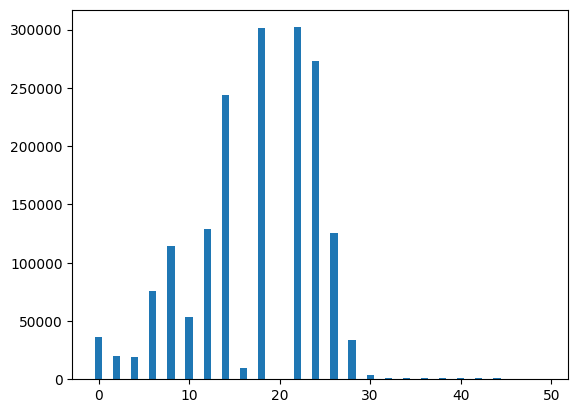

In [9]:
maxn = 50
plt.bar(np.arange(maxn), np.abs(fftshift(template_ft))[:maxn])


In [10]:
bus.data.options.set_manual(ratio=2)

ils_res = instrument.get_spectrum(temp_s=earth_twin['temp_s'],
                                        radius_s=earth_twin['radius_s'],
                                        distance_s=earth_twin['distance_s'],
                                        lat_s=earth_twin['lat_s'],
                                        z=earth_twin['z'],
                                        angsep=earth_twin['angsep'],
                                        flux_planet_spectrum=flux_planet_spectrum,
                                        integration_time=dbw['t_int'],
                                        exposure_time=dbw['t_exp'],
                                        n_rot=1,
                                        safe_mode=True,
                                        hyperrot_noise='zero')

Adjusted exposure time from 600 s to 599.58 s
Will simulate 1 rotations in 10.0 days
Total number of samples: 1441
Number of rotation angles: 1441
Creating astrophysical sources ... [Done]
Calculating gradient and Hessian coefficients ... [Done]
Generating planet signal ... [Done]
Shape of the planet template: (31, 1441)
Calculating fundamental noise ... [Done]
Calculating systematics noise (chopping) ... [Done]


In [11]:
template_ft_2 = temp2freq_fft(time_series=bus.modules['inst'].inst_prt.planet_template_chop[i, :],
                                          total_time=bus.modules['inst'].inst_prt.t_total)

# 2. Get Perturbation PSD

In [12]:
inst = instrument

In [13]:
inst.wl_bins[i]

1.0092572320117914e-05

In [14]:
d_a_rms, d_phi_rms, d_pol_rms, _, _ = rms_frequency_adjust(
    rms_mode=inst.rms_mode,
    wl=inst.wl_bins[i],
    d_a_rms=inst.d_a_rms,
    d_phi_rms=inst.d_phi_rms,
    d_pol_rms=inst.d_pol_rms,
    d_x_rms=None,
    d_y_rms=None
)

In [15]:
# create PSDs
d_a_psd, avg_d_a_2, d_a_b_2 = create_pink_psd(
    t_total=inst.t_total,
    n_sampling_max=int(len(inst.planet_template_chop[0])/2),
    harmonic_number_n_cutoff=inst.harmonic_number_n_cutoff['a'],
    rms=d_a_rms,
    num_a=inst.num_a,
    n_rot=inst.n_rot,
    hyperrot_noise=inst.hyperrot_noise
)

d_phi_psd, avg_d_phi_2, d_phi_b_2 = create_pink_psd(
    t_total=inst.t_total,
    n_sampling_max=int(len(inst.planet_template_chop[0])/2),
    harmonic_number_n_cutoff=inst.harmonic_number_n_cutoff['phi'],
    rms=d_phi_rms,
    num_a=inst.num_a,
    n_rot=inst.n_rot,
    hyperrot_noise=inst.hyperrot_noise
)

In [16]:
conv_psd = np.convolve(d_a_psd[0], d_phi_psd[0], mode='same')

In [17]:
np.abs(fftshift(d_a_psd[0][:-1]))[:maxn][0]

0.0

In [18]:
int(len(conv_psd)/2)

720

In [19]:
np.arange(-int(len(conv_psd)/2), int(len(conv_psd)/2) + 1)

array([-720, -719, -718, ...,  718,  719,  720])

(-30.0, 30.0)

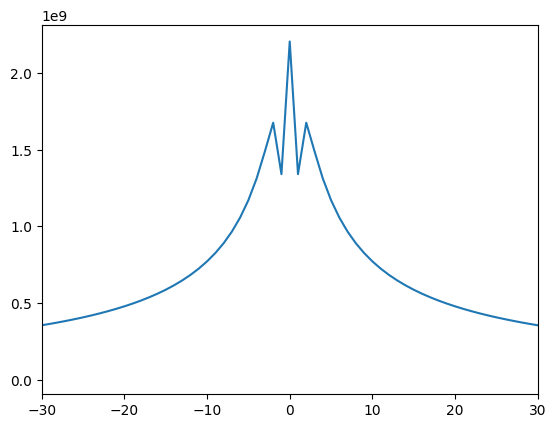

In [20]:
plt.plot(np.arange(-int(len(conv_psd)/2), int(len(conv_psd)/2) + 1), conv_psd)
plt.xlim(-30, 30)

In [21]:
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

#Direct input
plt.rcParams['text.latex.preamble']=r'\usepackage{lmodern} \usepackage{amsmath}'

#Options
params = {'text.usetex' : True,
          'font.size' : 8,
          'font.family' : 'lmodern',
          # 'text.latex.unicode': True,
          }
plt.rcParams.update(params)

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_65955/164952516.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  custom_patch = Rectangle((0, 0), 1, 1, color='none',


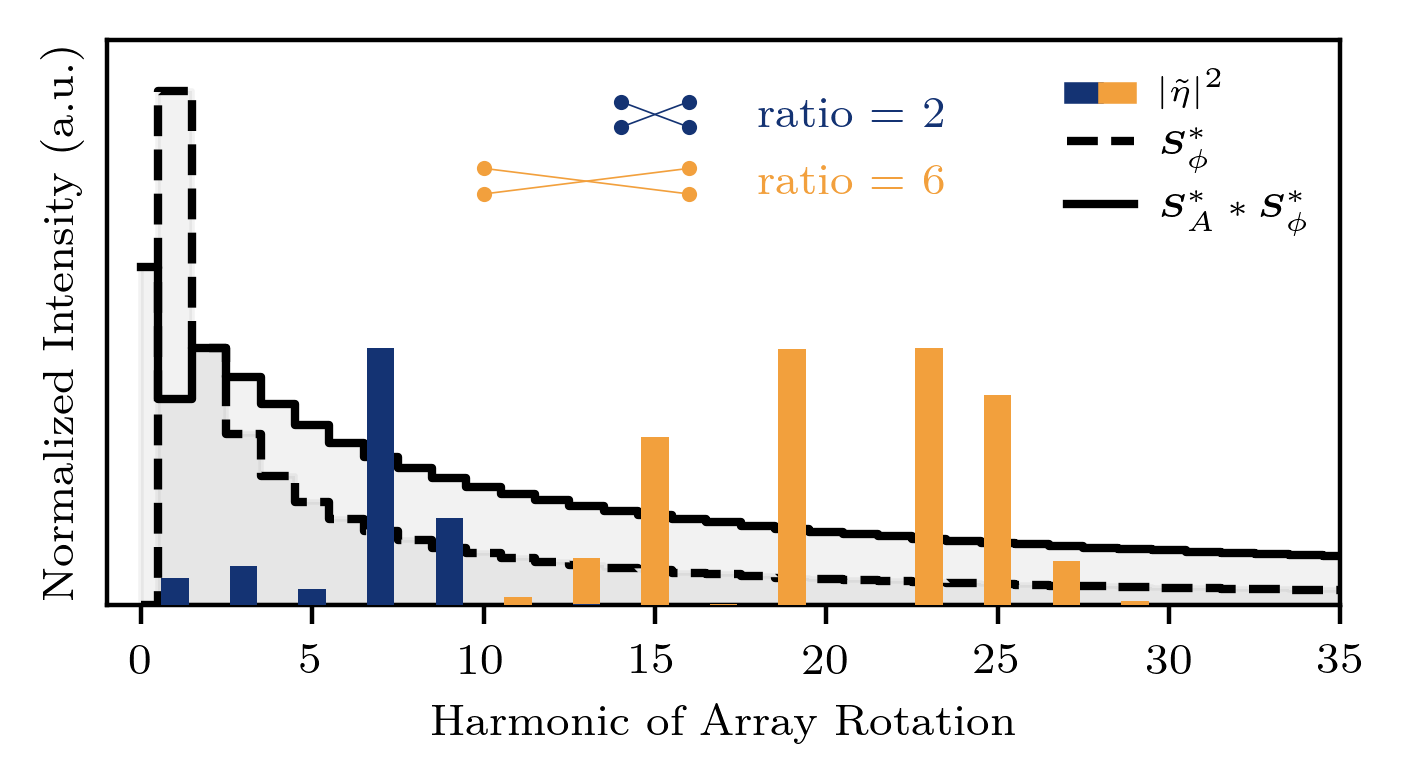

In [25]:
temp_scale = 0.5

# extract one single color from thermal colormap
cs = {'k': 'k',
      'orange': '#d95f02',
      'green': '#7570b3', # '#1b9e77',
      'blue': '#7570b3'}

cs = {'k': 'k',
      'orange': '#F2A03D',
      'green': '#143373', # '#1b9e77',
      'blue': '#7570b3'}

fig, ax = plt.subplots(figsize=(3.55, 2), dpi=400)

plt.step(np.arange(maxn), np.abs(fftshift(d_a_psd[0][:-1]))[:maxn] / np.max(np.abs(fftshift(d_a_psd[0]))[:maxn]), c='k', ls='--', where='mid', label=r'$\boldsymbol{S}_\phi^*$')

plt.fill_between(np.arange(maxn), np.abs(fftshift(d_a_psd[0][:-1]))[:maxn] / np.max(np.abs(fftshift(d_a_psd[0]))[:maxn]), step='mid', alpha=0.1, color='gray')

plt.step(np.arange(maxn), 
         np.abs(fftshift(conv_psd[:-1]))[:maxn] / np.max(np.abs(fftshift(conv_psd))[:maxn]) / 2,
         c='k', ls='-', where='mid', label=r'$\boldsymbol{S}_A^* \ast \boldsymbol{S}_\phi^*$')

plt.fill_between(np.arange(maxn), 
         np.abs(fftshift(conv_psd[:-1]))[:maxn] / np.max(np.abs(fftshift(conv_psd))[:maxn]) / 2,
                 step='mid',
                 alpha=0.1, color='gray')

plt.bar(np.arange(maxn), np.abs(fftshift(template_ft[:-1]**2))[:maxn] / np.max(np.abs(fftshift(template_ft[:-1]**2))[:maxn]) * temp_scale, color=cs['orange'], zorder=10, alpha=1)

plt.bar(np.arange(maxn), np.abs(fftshift(template_ft_2[:-1]**2))[:maxn] / np.max(np.abs(fftshift(template_ft_2[:-1]**2))[:maxn]) * temp_scale, color=cs['green'], zorder=10, alpha=1)

plt.xlim(-1, 35)
plt.ylim(0, 1.1)

plt.yticks([])
plt.xlabel('Harmonic of Array Rotation')
plt.ylabel('Normalized Intensity (a.u.)')

# Create a custom two-colored patch (half orange, half blue)
custom_patch = Rectangle((0, 0), 1, 1, color='none',
                         edgecolor='none')  # An invisible rectangle to hold the legend space

# Custom legend handler class to create a two-colored bar
class TwoColorPatchHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # Create two rectangles for the two colors
        
        height *= 0.7
        
        orange_patch = Rectangle([x0, y0], width / 2, height, transform=trans, color=cs['green'])
        blue_patch = Rectangle([x0 + width / 2, y0], width / 2, height, transform=trans, color=cs['orange'])
        
        return [orange_patch, blue_patch]

# Get the existing handles and labels for the sine and cosine plots
handles, labels = ax.get_legend_handles_labels()

# Append the custom patch to the handles and the corresponding label
handles.insert(0, custom_patch)
labels.insert(0, r'$| \tilde{\eta} |^2$')

# Add the custom patch and the existing entries to the legend
legend = ax.legend(handles=handles, labels=labels, handler_map={custom_patch: TwoColorPatchHandler()}, frameon=False, loc='upper right', fontsize=6)


x_2 = [16, 0.98]
b_2 = 0.05

pos_2 = np.array([x_2, 
         [x_2[0], x_2[1] - b_2],
         [x_2[0] - b_2*2*20, x_2[1] - b_2], 
         [x_2[0] - b_2*2*20, x_2[1]]])

x_6 = [16, 0.85]
b_6 = 0.05

pos_6 = np.array([x_6,
         [x_6[0], x_6[1] - b_6],
         [x_6[0] - b_6*6*20, x_6[1] - b_6], 
         [x_6[0] - b_6*6*20, x_6[1]]])

ax.scatter(pos_2[:, 0], pos_2[:, 1], s=3, c=cs['green'])
ax.scatter(pos_6[:, 0], pos_6[:, 1], c=cs['orange'], s=3)

ax.text(18, 0.95, 'ratio = 2', ha='left', va='center', fontsize=8, color=cs['green'])
ax.text(18, 0.82, 'ratio = 6', ha='left', va='center', fontsize=8, color=cs['orange'])

plt.plot([pos_2[0, 0], pos_2[2, 0]], [pos_2[0, 1], pos_2[2, 1]], c=cs['green'], lw=0.3)
plt.plot([pos_2[1, 0], pos_2[3, 0]], [pos_2[1, 1], pos_2[3, 1]], c=cs['green'], lw=0.3)

plt.plot([pos_6[0, 0], pos_6[2, 0]], [pos_6[0, 1], pos_6[2, 1]], c=cs['orange'], lw=0.3)
plt.plot([pos_6[1, 0], pos_6[3, 0]], [pos_6[1, 1], pos_6[3, 1]], c=cs['orange'], lw=0.3)

plt.tight_layout()
plt.show()

In [25]:
# give the array a new axis
np.array(color)[np.newaxis, :]

NameError: name 'color' is not defined

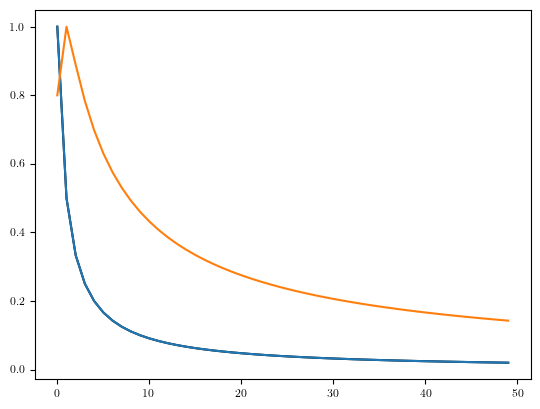

In [26]:
plt.plot(np.arange(maxn), np.abs(fftshift(d_a_psd[0]))[:maxn] / np.max(np.abs(fftshift(d_a_psd[0]))[:maxn]), c='k')
plt.plot(np.arange(maxn), np.abs(fftshift(d_phi_psd[0]))[:maxn] / np.max(np.abs(fftshift(d_phi_psd[0]))[:maxn]), c='tab:blue')
plt.plot(np.arange(maxn), np.abs(fftshift(conv_psd))[:maxn] / np.max(np.abs(fftshift(conv_psd))[:maxn]), c='tab:orange')